In [1]:
import json, requests, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, precision_recall_curve, roc_curve

username = 'HDaftary'
token = '<<secret>>'
session = requests.Session()
session.auth = (username, token)

# providing raw url to download csv from github
csv_url = 'https://raw.githubusercontent.com/HDaftary97/ML/main/Logistic%20Regression/train.csv'
download = session.get(csv_url).content

train = np.genfromtxt(io.StringIO(download.decode('utf-8')), skip_header=1, delimiter=',', dtype=str)

csv_url = 'https://raw.githubusercontent.com/HDaftary97/ML/main/Logistic%20Regression/test.csv'
download = session.get(csv_url).content

test = np.genfromtxt(io.StringIO(download.decode('utf-8')), skip_header=1, delimiter=',', dtype=str)

x_train = train[:, :-1].astype('float64')
y_train = train[:, -1].astype('int')

x_test = test[:, :-1].astype('float64')
y_test = test[:, -1].astype('int')

In general, features can have different types of values and ranges, which can significantly affect the performance
of the classifier. As a result, the first step after loading the data is to pre-process them and scale the
features in a similar range, using normalization techniques

When training without normalizing data, it is very probable that you see something like overflow/infinity/NaN. I encountered RuntimeWarning: overflow encountered in my line of code:
pyigivenx = np.exp(np.dot(theta, Xbar.T))
This happened because without normalizing data, the value of exp() tends to be very large (infinity).
Even by using sklearn LogisticRegression, I got ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In [2]:
# Below 2 lines same as x_train = StandardScaler().fit_transform(x_train)
fitted = StandardScaler().fit(x_train)  # fitted has training mean and std fitted.mean_ & fitted.var_
x_train = fitted.transform(x_train) # convert to x-mean_/var_

x_test = fitted.transform(x_test)

*Logistic Regression* starts!

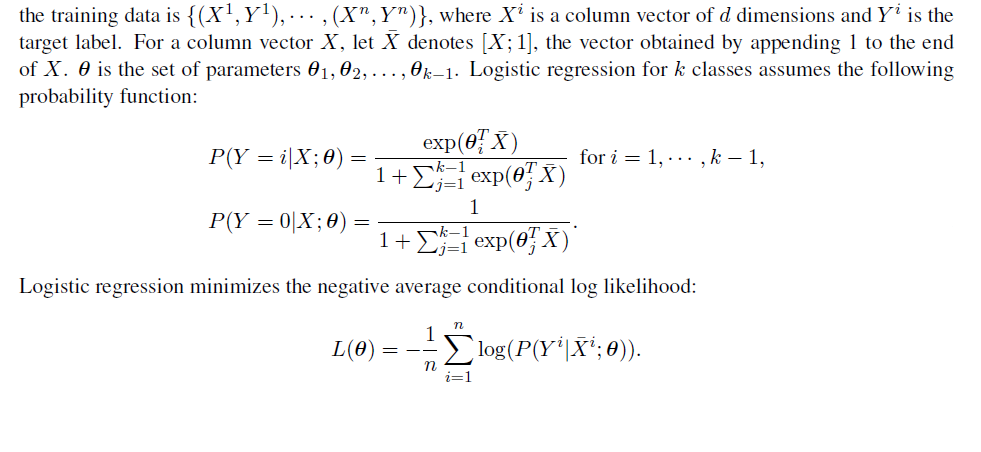

In [3]:
from IPython.display import Image, display
download = session.get('https://raw.githubusercontent.com/HDaftary97/ML/main/Logistic%20Regression/logisticregression.PNG').content
display(Image(download))

Inputs:
1. X: a two dimensional Numpy array of size n * d, where n is the number of data points, and d the dimension of the feature vectors.

2. y: a Numpy vector of length n. y[i] is a categorical label corresponding to the data point X[i; :]. You can assume that the number of classes k is the maximum entry of y + 1.

3. m; eta start; eta end; epsilon; max epoch are scalar parameters for the batch size, the starting learning
rate, the ending learning rate, the learning rate reduction criterion, and the maximum number of
epochs as described in the algorithm above.

Outputs:

1. W: a (k - 1)*d Numpy matrix
2. b: a Numpy vector of length k - 1 for the biases.

In [4]:
def logreg_fit(X, y, m, eta_start, eta_end, epsilon, max_epoch=1000):
    k = len(np.unique(y))
    d = X.shape[1]
    w = np.random.uniform(0, 1, (k - 1, d))
    b = np.random.uniform(0, 1, (k - 1,))

    coeff, costs = model_predict(w, b, m, X, y, eta_start, eta_end, epsilon, max_epoch)
    w = coeff["w"]
    b = coeff["b"]
    print('Costs are ', costs)

    assert w.shape == (k - 1, d)
    assert b.shape == (k - 1,)

    print('Optimized weights', w)
    print('Optimized intercept', b)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title('Cost reduction over time')
    plt.show()

    return w, b

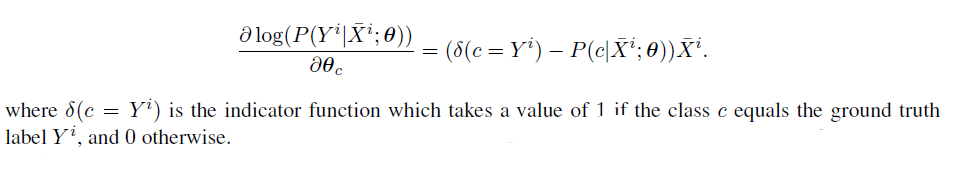

In [5]:
from IPython.display import Image, display
download = session.get('https://raw.githubusercontent.com/HDaftary97/ML/main/Logistic%20Regression/losswrttheta(1).PNG').content
display(Image(download))

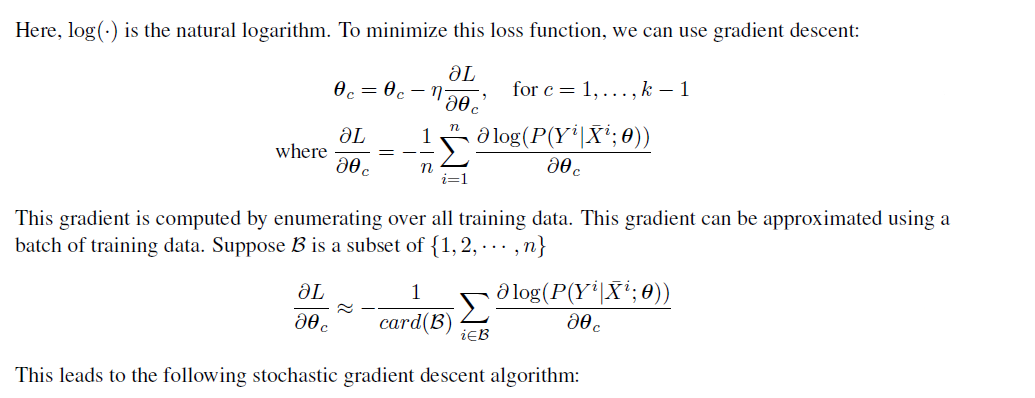

In [6]:
from IPython.display import Image, display
download = session.get('https://raw.githubusercontent.com/HDaftary97/ML/main/Logistic%20Regression/losswrttheta(2).PNG').content
display(Image(download))

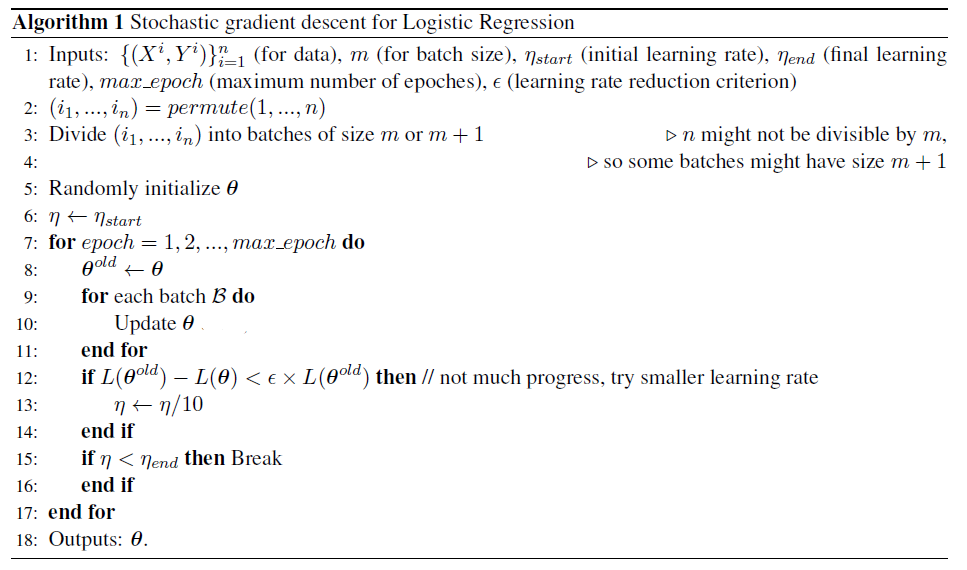

In [7]:
from IPython.display import Image, display
download = session.get('https://raw.githubusercontent.com/HDaftary97/ML/main/Logistic%20Regression/SGD.PNG').content
display(Image(download))

In [8]:
def model_predict(w, b, m, X, Y, eta_start, eta_end, epsilon, epochs):
    learning_rate = eta_start
    temp = np.concatenate((X, Y.reshape(-1, 1)), axis=1)
    temp = shuffle(temp)  # permute

    # dividing the training set into batches
    num_batch = int(temp.shape[0] / m)
    batches = np.array_split(temp, num_batch, axis=0)

    theta = np.concatenate((w, b.reshape(-1, 1)), axis=1)  # Adding bias for each classes

    costs = []

    for i in range(epochs):
        if i%10 == 0:
          print("Epoch number ", i)
        theta_old = theta
        for batch in batches:
            batch_x = batch[:, :-1]
            batch_y = batch[:, -1]
            batch_x_bar = np.concatenate((batch_x, np.ones(len(batch_x)).reshape(-1, 1)), axis=1)
            # For all the classes (k-1), update theta
            delta = loss_derivative_theta(theta.reshape(1, -1), batch_x_bar, batch_y)
            theta = theta - learning_rate * delta

        Xbar = np.concatenate((X, np.ones(len(X)).reshape(-1, 1)), axis=1)
        w_new = theta[:, :-1]
        b_new = theta[:, -1]
        assert w.shape == w_new.shape
        assert b.shape == b_new.shape
        w = w_new
        b = b_new

        loss_old = calculate_loss_function(theta_old, Xbar, Y)
        loss = calculate_loss_function(theta, Xbar, Y)
        if (loss_old - loss) < epsilon * loss_old:
            learning_rate = learning_rate / 10

        if learning_rate < eta_end:
            break
        costs.append(loss_old)

    # final parameters
    coeff = {"w": w, "b": b}
    return coeff, costs

In [9]:
def loss_derivative_theta(theta, xbar, y):  # return 1,d+1
    w = theta[:, :-1]
    b = theta[:, -1]
    x = xbar[:, :-1]
    yhat = logreg_predict_prob(w, b, x) 
    prob = np.delete(yhat, 0, axis=1)  # prob n, k-1
    return_value = np.zeros((len(y), xbar.shape[1]))

    # Using formula dl/dtheta = sum[Y - P(Y=i|X)]X)]
    for i in range(len(y)):
        return_value[i] = (y[i] - prob[i]) * xbar[i]  # 1 * 1,d+1

    all_training = np.sum(return_value, axis=0)  # axis = 0 is same number of columns 1,d+1
    all_training = all_training.reshape(1, -1)
    return (-1 / len(x)) * all_training

In [10]:
def calculate_loss_function(theta, xbar, y): # return is (k-1,d+1)
    # y=(n,), theta=(k-1,d+1), xbar=(n,d+1)
    w = theta[:, :-1]
    b = theta[:, -1]
    predicted_prob = logreg_predict_prob(w, b, xbar[:, :-1])
    true_class_prob = np.take_along_axis(predicted_prob, np.expand_dims(y, axis=1), axis=1)
    assert true_class_prob.shape == (len(y), 1)
    true_class_prob[true_class_prob == 0] = 1e-14
    loss = -1/len(y) * np.log(true_class_prob).sum() # This is loss for multi-class

    # L(theta) = - mean_over_all_training_examples[Y(thetaT [dot product] X) - log(1+e^(thetaT [dot product] X)]
    loss2 = -1 * np.mean(y * np.dot(theta, xbar.T) - np.log(1 + np.exp(np.dot(theta, xbar.T))))
    # Loss (calculated by me, valid only for binary classification

    return loss

In [11]:
def logreg_predict_prob(W, b, X):
    d = X.shape[1]  # Number of features
    n = X.shape[0]  # Number of examples
    k = W.shape[0] + 1  # Number of classes

    Xbar = np.concatenate((X, np.ones(n).reshape(-1, 1)), axis=1)  # Adding 1 to X such as 1*bias = bias
    theta = np.concatenate((W, b.reshape(-1, 1)), axis=1)  # Adding bias for each classes
    assert W.shape == (k - 1, d)
    assert b.shape == (k - 1,)
    assert Xbar.shape == (n, d + 1)
    assert theta.shape == (k - 1, d + 1)
    pyigivenx = np.exp(np.dot(theta, Xbar.T))  # shape is (k-1,n)
    prob = np.divide(pyigivenx, 1 + np.sum(pyigivenx, axis=0))  # shape is (k-1,n)
    prob_values_0 = 1 - np.sum(prob, axis=0)  # shape is (1,n)
    final_return = np.concatenate((prob_values_0.reshape(-1, 1), prob.reshape(-1, k-1)), axis=1)

    assert final_return.shape == (n, k)
    return final_return


def logreg_predict_class(W, b, X):
    P = logreg_predict_prob(W, b, X)
    n = P.shape[0]
    yhat = P.argmax(axis=1)
    assert yhat.shape == (n,)
    return yhat

Epoch number  0
Epoch number  10
Epoch number  20
Epoch number  30
Epoch number  40
Epoch number  50
Epoch number  60
Epoch number  70
Epoch number  80
Epoch number  90
Epoch number  100
Epoch number  110
Epoch number  120
Epoch number  130
Epoch number  140
Epoch number  150
Epoch number  160
Epoch number  170
Epoch number  180
Epoch number  190
Epoch number  200
Epoch number  210
Epoch number  220
Epoch number  230
Epoch number  240
Epoch number  250
Epoch number  260
Epoch number  270
Epoch number  280
Epoch number  290
Costs are  [2.962016903439274, 2.882510922591024, 2.8059126827352183, 2.7321733530502224, 2.66138775046756, 2.5933808384534727, 2.52813295213412, 2.4655201113757177, 2.4054301444483492, 2.3477551409722954, 2.2923754434955894, 2.2391605723569654, 2.187992640370863, 2.138745734539434, 2.091295521722012, 2.045524976282691, 2.001318729621638, 1.9585676203181668, 1.9171697214440278, 1.878406660401494, 1.8396875338889862, 1.8015554740212112, 1.7658162678981202, 1.729756428

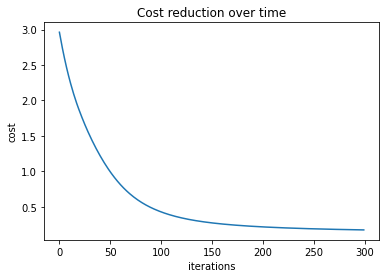

In [12]:
w,b = logreg_fit(x_train, y_train, 256, 0.01, 0.00001, 0.0001, max_epoch=300)

Accuracy of model for train dataset is  0.9395803183791607
Confusion matrix of model for train dataset is  [[2484   45]
 [ 122  113]]
Precision Score of model for train dataset is  0.7151898734177216


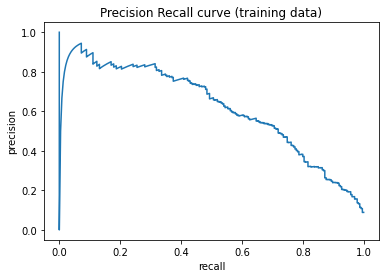

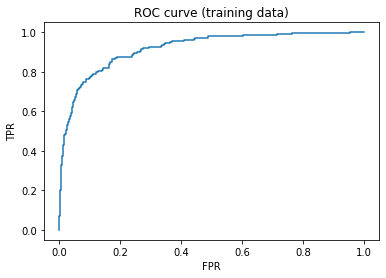

In [13]:
yhat = logreg_predict_class(w, b, x_train)
yhat_proba = logreg_predict_prob(w, b, x_train)

print("Accuracy of model for train dataset is ", accuracy_score(y_train, yhat))
print("Confusion matrix of model for train dataset is ", confusion_matrix(y_train, yhat))
print("Precision Score of model for train dataset is ", precision_score(y_train, yhat))
# precision value is bad as the logistic regression classifier is unable to classify correctly 
# the deaths (positive class), that is, false positive is too high (40).
precision, recall, thresholds = precision_recall_curve(y_train, yhat_proba[:, 1])
# since we take minority class for this, and here y=1 is the minority. Source : https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
# Also, in question it is given to find probabilities of the positive class (y = 1)

plt.plot(recall, precision)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('Precision Recall curve (training data)')
plt.show()

plt.figure()
fpr, tpr, threshold = roc_curve(y_train, yhat_proba[:, 1])
plt.plot(fpr, tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC curve (training data)')
plt.show()

Accuracy of model for test dataset is  0.9015918958031838
Confusion matrix of model for test dataset is  [[609  26]
 [ 42  14]]
Precision Score of model for test dataset is  0.35


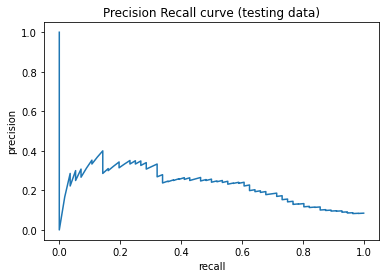

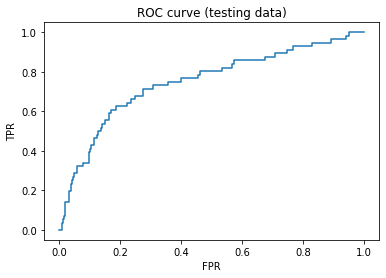

In [14]:
yhat = logreg_predict_class(w, b, x_test)
yhat_proba = logreg_predict_prob(w, b, x_test)

print("Accuracy of model for test dataset is ", accuracy_score(y_test, yhat))
print("Confusion matrix of model for test dataset is ", confusion_matrix(y_test, yhat))
print("Precision Score of model for test dataset is ", precision_score(y_test, yhat))
# precision value is bad as the logistic regression classifier is unable to classify correctly 
# the deaths (positive class), that is, false positive is too high (40).
precision, recall, thresholds = precision_recall_curve(y_test, yhat_proba[:, 1])
# since we take minority class for this, and here y=1 is the minority. Source : https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
# Also, in question it is given to find probabilities of the positive class (y = 1)

plt.plot(recall, precision)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('Precision Recall curve (testing data)')
plt.show()

plt.figure()
fpr, tpr, threshold = roc_curve(y_test, yhat_proba[:, 1])
plt.plot(fpr, tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC curve (testing data)')
plt.show()

Note: balanced accuracy = TPR+TNR/2